In [1]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time
import sys
%matplotlib inline
import random
import copy
import logging
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import keras.backend as K

# Setup logging.
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='LSTM-products.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)



Using TensorFlow backend.


In [2]:
def error_fun (real, prediccion):
    if prediccion <= (real + 0.1) and prediccion >= (real - 0.1):
        return 1
    else:
        return 0

In [3]:
class TimeSeriesNN3():
    def __init__(self,STEPS_AHEAD ,NUMBER_TESTING , SERIE, WINDOW):
        self.STEPS_AHEAD = STEPS_AHEAD
        self.WINDOW = WINDOW
        self.NUMBER_TESTING = NUMBER_TESTING
        self.SERIE = SERIE
        self.SIZE = SERIE.shape[0]
        self.NUMBER_TRAINING = self.SIZE - self.NUMBER_TESTING
    
    def divide_testing (self):
        return (self.SERIE[:self.NUMBER_TRAINING],self.SERIE[self.NUMBER_TRAINING:])
    
    def divide_validation (self,serie):
        experimentx = np.zeros((len(serie) - self.WINDOW -self.STEPS_AHEAD + 1, self.WINDOW))
        experimenty = np.zeros((len(serie) - self.WINDOW -self.STEPS_AHEAD + 1,1))
        cnt =  0
        cnt2 = 0
        #serie = serie.reset_index(drop = True)
        for i in range (experimentx.shape[0]):
            cnt += cnt2
            for j in range (self.WINDOW):
                experimentx[i][j] = serie[cnt]
                cnt += 1   
            experimenty[i] = serie[cnt + self.STEPS_AHEAD - 1]
            cnt = 0
            cnt2 += 1           
        return (experimentx, experimenty)
    
    def batch (self):
        training,testing = self.divide_testing()
        tex,tey = self.divide_validation(testing)
        tx,ty = self.divide_validation(training)        
        return (tx,ty) , (tex,tey)
Serie_1 = pd.read_csv('productos/269-00593.txt', sep="      ", header=[0,1])
Serie_1.values
Serie_1
scaler = MinMaxScaler(feature_range = (0, 1))
Serie_1 = scaler.fit_transform(Serie_1)  
Serie_1

C:\Users\hug0er\Anaconda3\envs\Tesis\lib\site-packages\ipykernel_launcher.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


array([[0.36363636],
       [0.66666667],
       [0.06060606],
       [0.36363636],
       [0.06060606],
       [0.16161616],
       [0.16161616],
       [0.36363636],
       [0.36363636],
       [0.06060606],
       [0.06060606],
       [0.06060606],
       [0.06060606],
       [0.36363636],
       [0.06060606],
       [0.06060606],
       [0.21212121],
       [0.06060606],
       [0.14141414],
       [0.06060606],
       [0.06060606],
       [0.57575758],
       [0.21212121],
       [0.32323232],
       [0.09090909],
       [0.1010101 ],
       [1.        ],
       [0.4040404 ],
       [0.54545455],
       [0.37373737],
       [0.67676768],
       [0.4040404 ],
       [0.06060606],
       [0.36363636],
       [0.19191919],
       [0.49494949],
       [0.35353535],
       [0.06060606],
       [0.46464646],
       [0.36363636],
       [0.36363636],
       [0.36363636],
       [0.21212121],
       [0.06060606],
       [0.65656566],
       [0.06060606],
       [0.46464646],
       [0.060

In [4]:
class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.2):
        """Create an optimizer.

        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated

        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.

        Args:
            count (int): Number of networks to generate, aka the
                size of the population

        Returns:
            (list): Population of network objects

        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.

        Args:
            pop (list): The population of networks

        Returns:
            (float): The average accuracy of the population

        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.

        Args:
            mother (dict): Network parameters
            father (dict): Network parameters

        Returns:
            (list): Two network objects

        """
        children = []
        for _ in range(2):

            child = {}

            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                child[param] = random.choice(
                    [mother.network[param], father.network[param]]
                )

            # Now create a network object.
            network = Network(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.

        Args:
            network (dict): The network parameters to mutate

        Returns:
            (Network): A randomly mutated network object

        """
        # Choose a random key.
        mutation = random.choice(list(self.nn_param_choices.keys()))

        # Mutate one of the params.
        network.network[mutation] = random.choice(self.nn_param_choices[mutation])

        return network

    def evolve(self, pop):
        """Evolve a population of networks.

        Args:
            pop (list): A list of network parameters

        Returns:
            (list): The evolved population of networks

        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            male = random.randint(0, parents_length-1)
            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [5]:
class Network():
    """Represent a network and let us operate on it.

    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.

        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        """Create a random network."""
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.

        Args:
            network (dict): The network parameters

        """
        self.network = network

    def train(self):
        """Train the network and record the accuracy.

        Args:
            dataset (str): Name of dataset to use.

        """
        if self.accuracy == 0.:
            self.accuracy = 1/train_and_score(self.network)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))

In [10]:


# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)


def compile_model(network, nb_classes):
    """Compile a sequential model.

    Args:
        network (dict): the parameters of the network

    Returns:
        a compiled network.

    """
    # Get our network parameters.
    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    i_neurons = network['i_neurons']
    activation = network['activation']
    optimizer = network['optimizer']

    model = Sequential()
    input_shape = (i_neurons, 1)
    print("input shape", input_shape)
  

    # Add each layer.
    for i in range(nb_layers - 1):

        # Need input shape for first layer.
        if i == 0:
            model.add(LSTM(units=nb_neurons, return_sequences=True, input_shape=input_shape, activation = activation)) 
            model.add(Dropout(0.2))  # hard-coded dropout
        else:
            model.add(LSTM(units=nb_neurons, return_sequences=True, activation = activation)) 
            model.add(Dropout(0.2))  # hard-coded dropout
    
    if (nb_layers - 1 == 0):
        model.add(LSTM(units=nb_neurons, activation = activation, input_shape=input_shape)) 
    else :
        model.add(LSTM(units=nb_neurons, activation = activation)) 
    # Output layer.
    model.add(Dense(units = 1))  
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_squared_error'])

    return model

def train_and_score(network):
    """Train the model, return test loss.

    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating

    """
    batch_size = 1
    i_neurons = network['i_neurons']
    # Set defaults.
    serie1 = TimeSeriesNN3(1,14,Serie_1,i_neurons)

    # Get the data.
    (x_train, y_train), (x_test, y_test) = serie1.batch()
    print(x_train.shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train, y_train = np.array(x_train), np.array(y_train)  
    x_test, y_test = np.array(x_test), np.array(y_test) 
    print(x_train.shape)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))  
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
    print(x_train.shape)
    model = compile_model(network, 1)

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10000,  # using early stopping, so no real limit
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[early_stopper])

    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)

    return score[1]  # 1 is accuracy. 0 is loss.

In [8]:

def train_networks(networks):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    pbar = tqdm(total=len(networks))
    for network in networks:
        network.train()
        pbar.update(1)
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.

    Args:
        networks (list): List of networks

    Returns:
        float: The average accuracy of a population of networks.

    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices):
    """Generate a network with the genetic algorithm.

    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating

    """
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)

        # Evolve, except on the last iteration.
        if (i != generations - 1):
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])
    print(networks[:5])

def print_networks(networks):
    """Print a list of networks.

    Args:
        networks (list): The population of networks

    """
    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    generations = 8  # Number of times to evole the population.
    population = 40  # Number of networks in each generation.

    nn_param_choices = {
        'nb_neurons': [12,7,14,21,16,20,24,28,32],
        'i_neurons': [8,7,9],
        'nb_layers': [1, 2, 3, 4],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['adam', 'sgd'],
    }

    logging.info("***Evolving %d generations with population %d***" %
                 (generations, population))

    generate(generations, population, nn_param_choices)



In [20]:
main()


    



  0%|          | 0/20 [00:00<?, ?it/s]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021305516362190247, 0.021305516362190247]




  5%|▌         | 1/20 [01:51<35:20, 111.63s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.030034001916646957, 0.030034001916646957]




 10%|█         | 2/20 [05:10<41:19, 137.77s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.026955828070640564, 0.026955828070640564]




 15%|█▌        | 3/20 [07:00<36:41, 129.50s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02206357568502426, 0.02206357568502426]




 20%|██        | 4/20 [09:29<36:03, 135.20s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021745825186371803, 0.021745825186371803]




 25%|██▌       | 5/20 [16:46<56:29, 225.99s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021052906289696693, 0.021052906289696693]




 30%|███       | 6/20 [20:56<54:23, 233.10s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.02213737741112709, 0.02213737741112709]




 35%|███▌      | 7/20 [23:41<46:02, 212.51s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.022406360134482384, 0.022406360134482384]




 40%|████      | 8/20 [30:02<52:38, 263.17s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.02633230946958065, 0.02633230946958065]




 45%|████▌     | 9/20 [37:40<58:58, 321.71s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021436328068375587, 0.021436328068375587]




 50%|█████     | 10/20 [41:38<49:24, 296.42s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.021383432671427727, 0.021383432671427727]




 55%|█████▌    | 11/20 [43:33<36:17, 241.97s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.024700304493308067, 0.024700304493308067]




 60%|██████    | 12/20 [45:59<28:27, 213.40s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.029490018263459206, 0.029490018263459206]




 65%|██████▌   | 13/20 [51:02<28:01, 240.22s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.022397492080926895, 0.022397492080926895]




 70%|███████   | 14/20 [1:01:08<35:00, 350.01s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.02252112329006195, 0.02252112329006195]




 75%|███████▌  | 15/20 [1:04:23<25:16, 303.39s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.02334209904074669, 0.02334209904074669]




 80%|████████  | 16/20 [1:07:11<17:30, 262.72s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.024578329175710678, 0.024578329175710678]




 85%|████████▌ | 17/20 [1:13:34<14:56, 298.94s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.0226892102509737, 0.0226892102509737]




 90%|█████████ | 18/20 [1:17:43<09:27, 283.83s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.026057643815875053, 0.026057643815875053]




 95%|█████████▌| 19/20 [1:23:09<04:56, 296.63s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.022494126111268997, 0.022494126111268997]




100%|██████████| 20/20 [1:27:18<00:00, 282.22s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.024130096659064293, 0.024130096659064293]




 55%|█████▌    | 11/20 [05:26<04:26, 29.64s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021907472983002663, 0.021907472983002663]




 60%|██████    | 12/20 [11:36<17:34, 131.82s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.022926433011889458, 0.022926433011889458]




 65%|██████▌   | 13/20 [17:09<22:25, 192.24s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021379059180617332, 0.021379059180617332]




 70%|███████   | 14/20 [21:08<20:37, 206.30s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.023772690445184708, 0.023772690445184708]




 75%|███████▌  | 15/20 [26:50<20:35, 247.00s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.023204438388347626, 0.023204438388347626]




 80%|████████  | 16/20 [29:50<15:07, 226.99s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.023586062714457512, 0.023586062714457512]




 85%|████████▌ | 17/20 [33:26<11:10, 223.54s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.02445429004728794, 0.02445429004728794]




 90%|█████████ | 18/20 [36:15<06:54, 207.27s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021633440628647804, 0.021633440628647804]




 95%|█████████▌| 19/20 [39:39<03:26, 206.16s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02122805453836918, 0.02122805453836918]




100%|██████████| 20/20 [44:33<00:00, 232.60s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.02261793427169323, 0.02261793427169323]




 55%|█████▌    | 11/20 [05:23<04:24, 29.43s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.023550326004624367, 0.023550326004624367]




 60%|██████    | 12/20 [07:42<08:17, 62.21s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021831708028912544, 0.021831708028912544]




 65%|██████▌   | 13/20 [10:53<11:46, 100.98s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02142302878201008, 0.02142302878201008]




 70%|███████   | 14/20 [21:30<26:10, 261.67s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.02232522703707218, 0.02232522703707218]




 75%|███████▌  | 15/20 [28:34<25:51, 310.25s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021870082244277, 0.021870082244277]




 80%|████████  | 16/20 [34:25<21:29, 322.48s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.023991987109184265, 0.023991987109184265]




 85%|████████▌ | 17/20 [36:56<13:33, 271.30s/it]

(179, 9)
(179, 9)
(179, 9, 1)
input shape (9, 1)
[0.02357415296137333, 0.02357415296137333]




 90%|█████████ | 18/20 [40:47<08:38, 259.16s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.020640574395656586, 0.020640574395656586]




 95%|█████████▌| 19/20 [49:37<05:40, 340.27s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.020947515964508057, 0.020947515964508057]




100%|██████████| 20/20 [54:27<00:00, 325.12s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.025991225615143776, 0.025991225615143776]




 45%|████▌     | 9/20 [02:06<02:34, 14.01s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.0275829266756773, 0.0275829266756773]




 50%|█████     | 10/20 [06:03<13:29, 80.93s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.023497680202126503, 0.023497680202126503]




 55%|█████▌    | 11/20 [11:50<24:06, 160.76s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.027464091777801514, 0.027464091777801514]




 60%|██████    | 12/20 [17:58<29:43, 222.91s/it]

(181, 7)
(181, 7)
(181, 7, 1)
input shape (7, 1)
[0.02248132787644863, 0.02248132787644863]




 65%|██████▌   | 13/20 [25:36<34:15, 293.59s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021805280819535255, 0.021805280819535255]




 70%|███████   | 14/20 [30:56<30:08, 301.34s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02369365654885769, 0.02369365654885769]




 75%|███████▌  | 15/20 [33:14<21:02, 252.57s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.01949598640203476, 0.01949598640203476]




 80%|████████  | 16/20 [37:58<17:27, 261.90s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02222576178610325, 0.02222576178610325]




 85%|████████▌ | 17/20 [43:31<14:09, 283.29s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021516749635338783, 0.021516749635338783]




 90%|█████████ | 18/20 [48:51<09:48, 294.33s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02087242901325226, 0.02087242901325226]




 95%|█████████▌| 19/20 [55:00<05:16, 316.78s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.022788256406784058, 0.022788256406784058]




100%|██████████| 20/20 [59:59<00:00, 311.29s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.020558452233672142, 0.020558452233672142]




 50%|█████     | 10/20 [05:54<05:54, 35.41s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.026418006047606468, 0.026418006047606468]




 55%|█████▌    | 11/20 [10:22<15:47, 105.31s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.020914390683174133, 0.020914390683174133]




 60%|██████    | 12/20 [15:11<21:22, 160.31s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02228081040084362, 0.02228081040084362]




 65%|██████▌   | 13/20 [21:16<25:53, 221.88s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.020992964506149292, 0.020992964506149292]




 70%|███████   | 14/20 [26:30<24:56, 249.44s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02390092797577381, 0.02390092797577381]




 75%|███████▌  | 15/20 [31:18<21:44, 260.91s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02353345789015293, 0.02353345789015293]




 80%|████████  | 16/20 [34:14<15:42, 235.56s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.024499302729964256, 0.024499302729964256]




 85%|████████▌ | 17/20 [36:50<10:34, 211.54s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.021078800782561302, 0.021078800782561302]




 90%|█████████ | 18/20 [46:30<10:44, 322.17s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.013048987835645676, 0.013048987835645676]




 95%|█████████▌| 19/20 [1:01:58<08:23, 503.97s/it]

(180, 8)
(180, 8)
(180, 8, 1)
input shape (8, 1)
[0.02283422090113163, 0.02283422090113163]




100%|██████████| 20/20 [1:04:27<00:00, 397.51s/it]

[<__main__.Network object at 0x0000022F99C973C8>, <__main__.Network object at 0x0000022F5F898D30>, <__main__.Network object at 0x0000022EF2E7B4A8>, <__main__.Network object at 0x0000022F2AE95A90>, <__main__.Network object at 0x0000022F5F898B38>]


In [21]:
# Helper: Early stopping.
logging.info('entrada')
early_stopper = EarlyStopping(patience=10)

batch_size = 1
i_neurons = 8
nb_layers = 1
nb_neurons = 20
activation = 'relu'
optimizer = 'adam'
nb_classes = 1



model = Sequential()
input_shape = (i_neurons, )



# Add each layer.
for i in range(nb_layers):

    # Need input shape for first layer.
    if i == 0:
        model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))
    else:
        model.add(Dense(nb_neurons, activation=activation))

    model.add(Dropout(0.2))  # hard-coded dropout

# Output layer.
model.add(Dense(nb_classes, activation=activation))

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_squared_error'])


# Set defaults.
serie1 = TimeSeriesNN3(1,14,Serie_1,i_neurons)

# Get the data.
(x_train, y_train), (x_test, y_test) = serie1.batch()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10000,  # using early stopping, so no real limit
          verbose=0,
          validation_data=(x_test, y_test),
          callbacks=[early_stopper])

score = model.evaluate(x_test, y_test, verbose=0)
print(score)
logging.info('salida')

[0.021304383873939514, 0.021304383873939514]


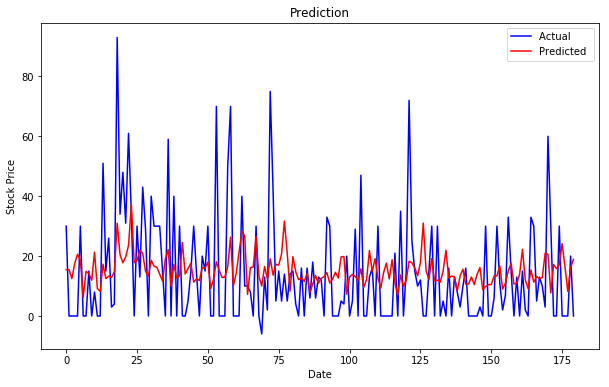

In [22]:
predictions = model.predict(x_train)  
predictions = scaler.inverse_transform(predictions) 
labelsf = scaler.inverse_transform( y_train) 
plt.figure(figsize=(10,6))  
plt.plot(labelsf, color='blue', label='Actual ')  
plt.plot(predictions , color='red', label='Predicted ')  
plt.title('Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  

In [23]:
def error_fun_list (lista_predicciones, lista_real):
    cnt_total = 0
    cnt_aciertos = 0
    for i in range (0, len(lista_predicciones)):
        if lista_predicciones[i] <= (lista_real[i] + 0.1) and lista_predicciones[i] >= (lista_real[i] - 0.1):
            cnt_aciertos += 1
        cnt_total += 1
    accuracy = cnt_aciertos/cnt_total
    print ("aciertos totales",cnt_aciertos, "total", cnt_total )
    print ("accuracy", accuracy)
    return accuracy

In [24]:
predictions = model.predict(x_train) 
predictions
y_train
error_fun_list(predictions,y_train)

aciertos totales 60 total 180
accuracy 0.3333333333333333


0.3333333333333333